In [80]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import csv
import scipy.stats as stats
from decimal import Decimal
from keras.models import Sequential
from keras.layers import Convolution1D, Flatten, Dense, Dropout, Softmax,MaxPooling1D, AvgPool1D, Conv1D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample

import os
import pandas as pd
import numpy as np
import pywt

In [4]:
!pip install wfdb

In [5]:
import wfdb
from wfdb import rdann
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

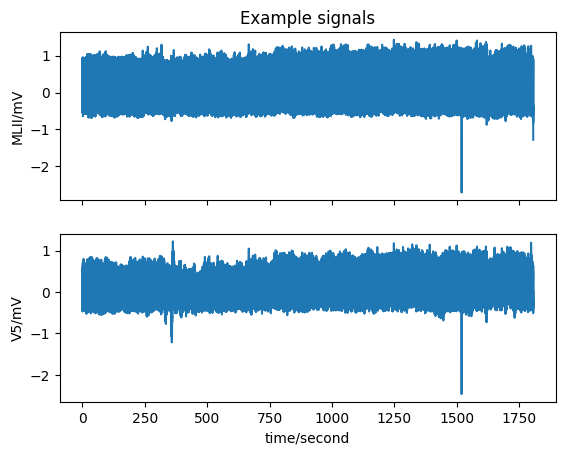

In [6]:
record = wfdb.rdrecord('/content/drive/MyDrive/EKG/mit-bih-arrhythmia-database-1.0.0/100')
wfdb.plot_wfdb(record=record, title='Example signals')

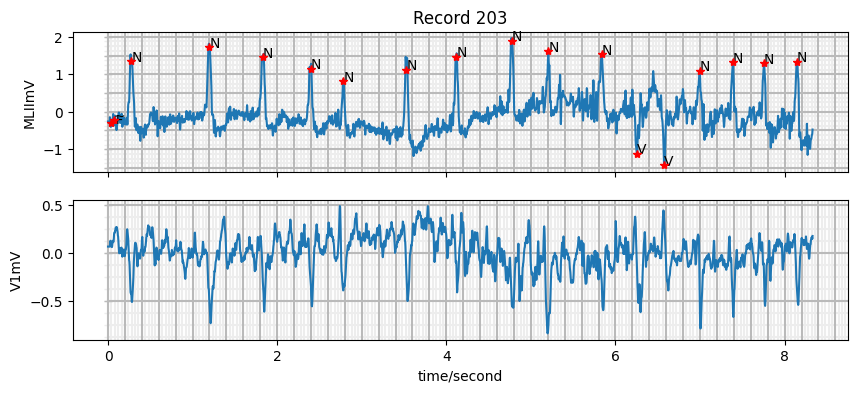

In [10]:
record = wfdb.rdrecord('/content/drive/MyDrive/EKG/mit-bih-arrhythmia-database-1.0.0/203', sampto=3000)
annotation = wfdb.rdann('/content/drive/MyDrive/EKG/mit-bih-arrhythmia-database-1.0.0/203', 'atr', sampto=3000)
wfdb.plot_wfdb(record=record, annotation=annotation, plot_sym=True, time_units='seconds', title='Record 203', figsize=(10,4), ecg_grids='all')

In [11]:
df = record.to_dataframe()
df.head()

,MLII,V1
0 days 00:00:00,-0.26,0.065
0 days 00:00:00.002777777,-0.26,0.065
0 days 00:00:00.005555554,-0.26,0.065
0 days 00:00:00.008333331,-0.26,0.065
0 days 00:00:00.011111108,-0.26,0.065


In [22]:
print(annotation.sample)
print(annotation.symbol)
print(annotation.contained_labels)
print(len(annotation.sample), len(annotation.symbol))

[  14   24   99  431  660  862 1002 1270 1483 1719 1874 2102 2251 2368
 2518 2659 2792 2933]
['+', '~', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'V', 'N', 'N', 'N', 'N']
None
18 18


In [23]:
wfdb.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed QRS detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


In [ ]:
# @title
data_path = '/content/drive/MyDrive/EKG/EKG_files/'

In [18]:
# @title
patient_100_file = data_path+"200.csv"
ecg100 = pd.read_csv(patient_100_file, index_col=0)
print(ecg100)

ecg100[0:1000]["'MLII'"].plot()
plt.title("First 4 heartbeats of patient 100's EKG")

In [ ]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

<Axes: >

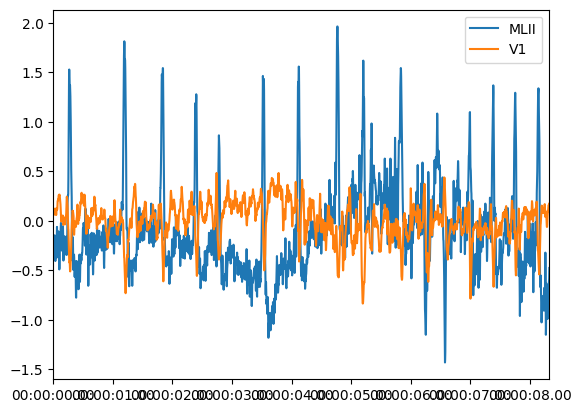

In [24]:
df.plot()

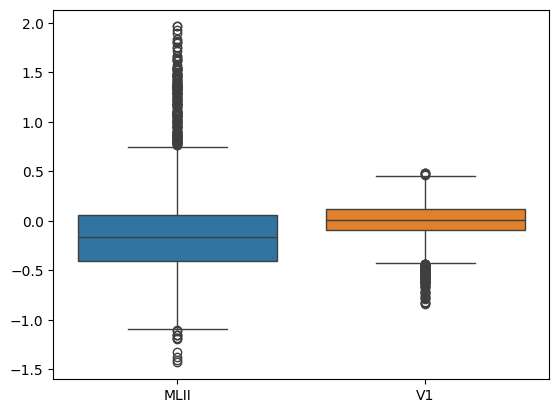

In [25]:
sns.boxplot(data=df)
plt.show()

**Classes:**
- N - Normal beat
- L - Left bundle branch block beat
- R - Right bundle branch block beat
- A - Atrial premature beat
- V - Premature ventricular contraction

In [26]:
directory = '/content/drive/MyDrive/EKG/EKG_files/'
records = []
annotations = []

for ekg_file in os.listdir(directory):
  if ekg_file.endswith('.csv'):
    records.append(directory + ekg_file)
  elif ekg_file.endswith('.txt'):
    annotations.append(directory + ekg_file)

In [30]:
print(len(records))
print(len(annotations))

48
48


In [36]:
window_size = 180
maximum_counting = 10000
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes
X = list()
y = list()

In [31]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04
    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
    datarec = pywt.waverec(coeffs, 'sym4')
    return datarec

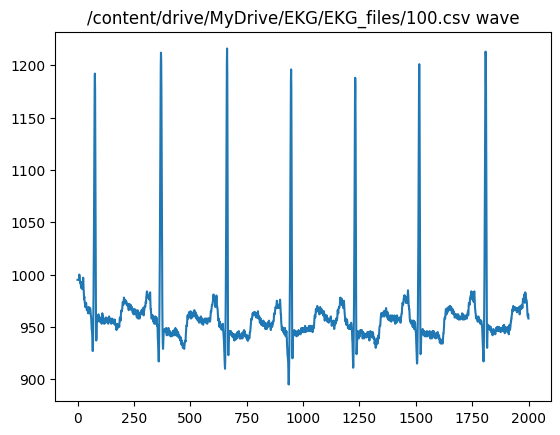

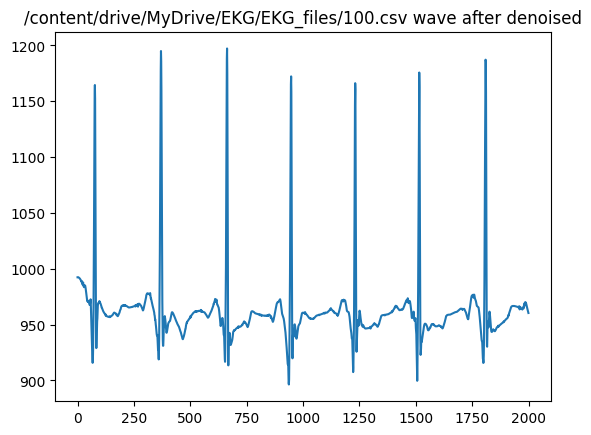

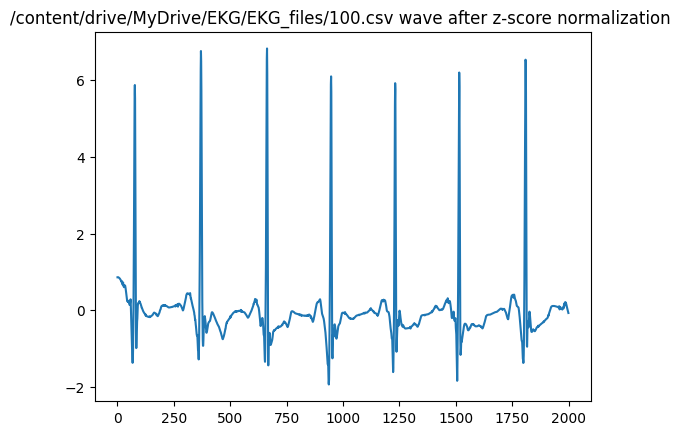

In [37]:
for i in range(len(records)):
    signals = []

    with open(records[i], 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')

        for index, row in enumerate(reader):
            if(index > 0):
              signals.insert(int(Decimal(row[0])), int(Decimal(row[1])))
    if i == 0:
        plt.title(records[0] + " wave")
        plt.plot(signals[0:2000])
        plt.show()

    signals = denoise(signals)

    if i == 0:
        plt.title(records[0] + "after denoised")
        plt.plot(signals[0:2000])
        plt.show()

    signals = stats.zscore(signals)

    if i == 0:
        plt.title(records[0] + "after z-score normalization")
        plt.plot(signals[0:2000])
        plt.show()

    with open(annotations[r], 'r') as file_an:
        data = file_an.readlines()
        beat = list()

        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1

                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]

                    X.append(beat)
                    y.append(arrhythmia_index)


In [42]:
print(len(X))
print(len(y))

100012
100012


In [45]:
y_df = pd.DataFrame(y)
per_class = y_df[y_df.shape[1]-1].value_counts()
print(per_class)

0
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


In [44]:
X_df = pd.DataFrame(X)
X_df

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.014193,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140757,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,-0.005353,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.014056,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.024847,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100007,-0.510727,-0.539047,-0.524613,-0.513211,-0.504754,-0.498109,-0.491093,-0.484136,-0.477553,-0.470754,...,-0.463169,-0.439494,-0.430399,-0.421124,-0.423520,-0.430418,-0.433909,-0.438028,-0.445370,-0.448886
100008,-0.509656,-0.499730,-0.494129,-0.473506,-0.455168,-0.407847,-0.400153,-0.388124,-0.383053,-0.375025,...,-0.445527,-0.454989,-0.465046,-0.473427,-0.481465,-0.492756,-0.503407,-0.514734,-0.523731,-0.519780
100009,-0.519925,-0.537361,-0.526609,-0.518580,-0.511395,-0.484212,-0.470345,-0.503313,-0.551100,-0.521429,...,-0.379091,-0.373974,-0.364478,-0.355834,-0.348003,-0.348027,-0.350071,-0.357147,-0.365169,-0.356411
100010,-0.545037,-0.545228,-0.524863,-0.519145,-0.513920,-0.504178,-0.493372,-0.486261,-0.480254,-0.474059,...,-0.261094,-0.273813,-0.290822,-0.305970,-0.321444,-0.339557,-0.355757,-0.374960,-0.390478,-0.382369


In [47]:
X_new_df = pd.concat([X_df, y_df],axis=1)
ax=list(range(361))
X_new_df = X_new_df.set_axis(ax, axis='columns')

X_new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095,0
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478,0
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259,0
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388,0
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073,0


In [55]:
# We randomly select 10.000 correct heartbeats and take all other arrhythmia categories

df_0 =(X_new_df[X_new_df[X_new_df.shape[1]-1]==0]).sample(n=10000, random_state=42)
df_1 = X_new_df[X_new_df[X_new_df.shape[1]-1]==1] # 8071 samples
df_2 = X_new_df[X_new_df[X_new_df.shape[1]-1]==2] # 7255 samples
df_3 = X_new_df[X_new_df[X_new_df.shape[1]-1]==3] # only 2546 samples
df_4 = X_new_df[X_new_df[X_new_df.shape[1]-1]==4] # 7129 samples

# We balance class 3 using resampling - upsampling to 5000 samples
df_3_upsample = resample(df_3,replace=True,n_samples=5000,random_state=125)

X_new_df = pd.concat([df_0, df_1,df_2, df_3_upsample, df_4])

In [56]:
X_new_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
77071,1.480281,1.433374,1.373250,1.327566,1.250747,1.187782,1.123472,1.049085,0.987568,0.909422,...,-0.363279,-0.389651,-0.389548,-0.389589,-0.390171,-0.390910,-0.391513,-0.391765,-0.392168,0
50905,-0.461486,-0.434447,-0.423375,-0.432222,-0.452664,-0.485181,-0.533628,-0.585172,-0.650934,-0.712356,...,-0.204523,-0.206719,-0.208836,-0.210980,-0.213460,-0.214244,-0.214475,-0.220744,-0.228728,0
46226,0.910031,1.093314,1.203378,1.264778,1.272679,1.207259,1.088586,0.957858,0.799045,0.574328,...,-0.461869,-0.450863,-0.453723,-0.455661,-0.433669,-0.410734,-0.439803,-0.488336,-0.536810,0
25793,0.420673,0.429527,0.438930,0.448001,0.457446,0.467491,0.471207,0.480483,0.486420,0.492279,...,0.186221,0.189590,0.193652,0.198072,0.202806,0.208187,0.213811,0.218627,0.223266,0
32029,-0.174938,-0.170075,-0.183134,-0.166396,-0.176061,-0.163881,-0.164358,-0.154193,-0.155828,-0.144012,...,-0.126126,-0.129452,-0.130908,-0.136692,-0.135770,-0.126619,-0.155829,-0.140649,-0.127331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97303,0.021134,-0.015162,-0.041568,-0.062246,-0.079418,-0.107518,-0.137208,-0.164484,-0.189460,-0.204799,...,-0.284917,-0.286850,-0.288368,-0.291412,-0.284522,-0.289233,-0.291870,-0.287175,-0.286683,4
97307,-0.364318,-0.384068,-0.387822,-0.382685,-0.380579,-0.375268,-0.351846,-0.324392,-0.295982,-0.270880,...,-0.450792,-0.458035,-0.464202,-0.465661,-0.466265,-0.462133,-0.449560,-0.472081,-0.446580,4
98839,0.349940,0.307741,0.288381,0.300836,0.379126,0.523458,0.715233,0.986651,1.385923,1.890071,...,0.031138,0.029152,0.028809,0.023494,0.015907,0.023864,0.035423,0.019140,-0.004215,4
99239,-0.166251,-0.148240,-0.214735,-0.301176,-0.315642,-0.324376,-0.272524,-0.135019,0.110707,0.476593,...,0.065617,0.061111,0.050046,0.032332,0.012625,0.024623,0.043128,0.043963,0.039879,4


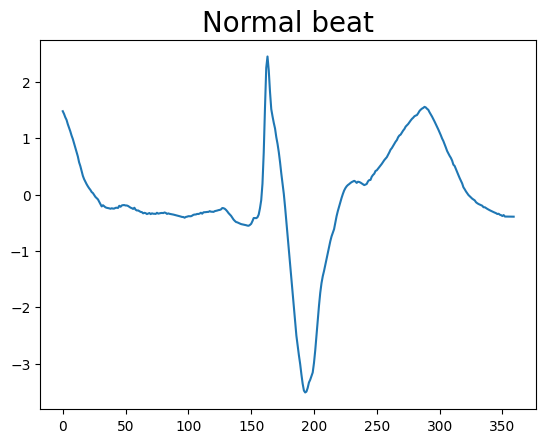

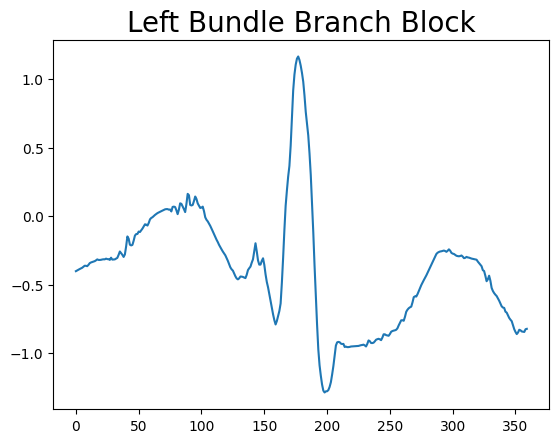

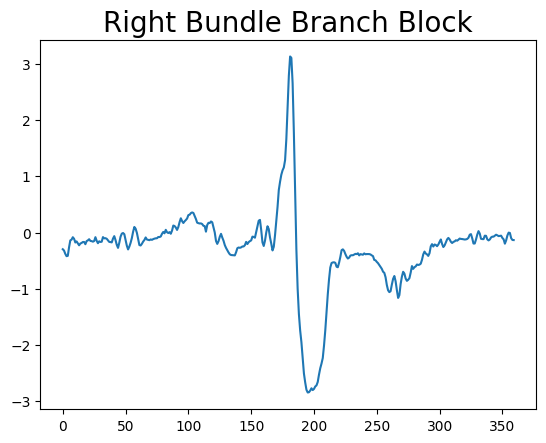

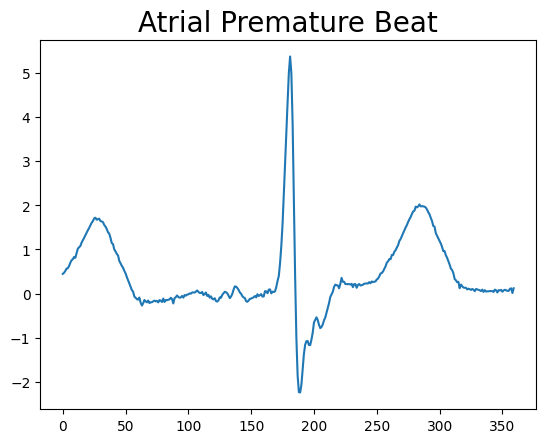

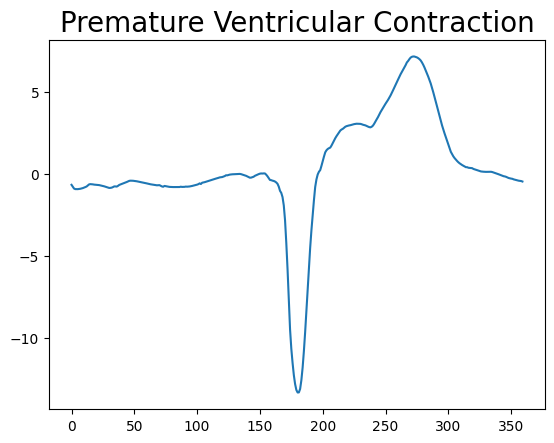

In [78]:
titles = ['Normal beat', 'Left Bundle Branch Block', 'Right Bundle Branch Block', 'Atrial Premature Beat', 'Premature Ventricular Contraction']

def plot_beat(i, title):
  df = X_new_df[X_new_df[X_new_df.shape[1]-1]==i]

  plt.plot(df.iloc[0][:-1])
  plt.title(title, fontsize=20)
  plt.show()


for i, title in enumerate(titles):
  plot_beat(i, title)

In [79]:
X = X_new_df[X_new_df.columns[:-1]]
y = X_new_df.iloc[:,-1:]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(29964, 360) (29964, 1)
(7491, 360) (7491, 1)


**SVM**

In [81]:
from sklearn.svm import SVC
svm_model = SVC(cache_size=500, verbose = True)

svm_model.fit(x_train, y_train.values.ravel())

[LibSVM]

SVC(cache_size=500, verbose=True)

In [82]:
svm_model.score(x_train, y_train.values.ravel())

0.8873648378053665

In [83]:
y_pred = svm_model.predict(x_test)

In [84]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.8707782672540382

Confusion Matrix:
 [[1824   16   82    9   20]
 [  20 1631    0    0    5]
 [ 204    2 1231    3    3]
 [ 161    2    8  863    8]
 [ 383   14   27    1  974]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.93      0.80      1951
           1       0.98      0.98      0.98      1656
           2       0.91      0.85      0.88      1443
           3       0.99      0.83      0.90      1042
           4       0.96      0.70      0.81      1399

    accuracy                           0.87      7491
   macro avg       0.91      0.86      0.88      7491
weighted avg       0.89      0.87      0.87      7491



**CNN**

In [89]:
train, test = train_test_split(X_new_df, test_size=0.20, random_state=7)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (29964, 361)
X_test  :  (7491, 361)


In [90]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(29964, 5) (7491, 5)


In [91]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(X_train), np.shape(X_test))

(29964, 360, 1) (7491, 360, 1)


In [93]:
model = Sequential()
model.add(Convolution1D(filters=16, kernel_size=7, strides=1, padding='same' , activation = 'relu', input_shape=(360,1)))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(Convolution1D(filters=32, kernel_size=9, strides=1, padding='same' , activation = 'relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(Convolution1D(filters=64, kernel_size=11, strides=1, padding='same' , activation = 'relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(Convolution1D(filters=128, kernel_size=13, strides=1, padding='same' , activation = 'relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 360, 16)           128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 179, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 179, 32)           4640      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 89, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 89, 64)            22592     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 44, 64)           

In [94]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [95]:
history = model.fit(X_train, y_train, batch_size=30, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
999/999 [==============================] - 125s 123ms/step - loss: 0.4921 - accuracy: 0.8211 - val_loss: 0.2830 - val_accuracy: 0.8991
Epoch 2/20
999/999 [==============================] - 77s 77ms/step - loss: 0.2627 - accuracy: 0.9051 - val_loss: 0.2237 - val_accuracy: 0.9175
Epoch 3/20
999/999 [==============================] - 72s 72ms/step - loss: 0.2246 - accuracy: 0.9162 - val_loss: 0.2068 - val_accuracy: 0.9247
Epoch 4/20
999/999 [==============================] - 74s 74ms/step - loss: 0.2018 - accuracy: 0.9249 - val_loss: 0.1931 - val_accuracy: 0.9295
Epoch 5/20
999/999 [==============================] - 70s 70ms/step - loss: 0.1907 - accuracy: 0.9269 - val_loss: 0.1875 - val_accuracy: 0.9307
Epoch 6/20
999/999 [==============================] - 85s 85ms/step - loss: 0.1781 - accuracy: 0.9317 - val_loss: 0.1798 - val_accuracy: 0.9311
Epoch 7/20
999/999 [==============================] - 77s 77ms/step - loss: 0.1647 - accuracy: 0.9346 - val_loss: 0.1812 - val_accurac

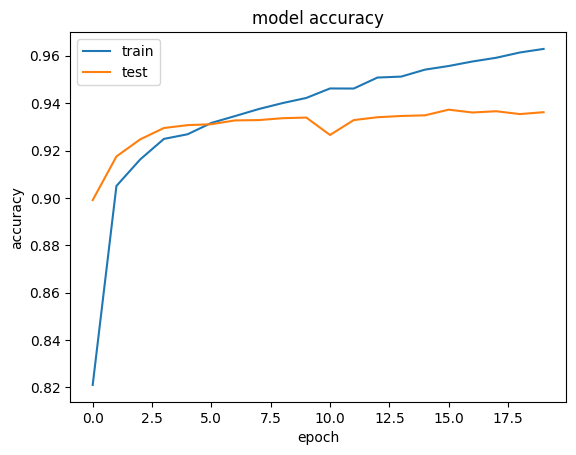

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

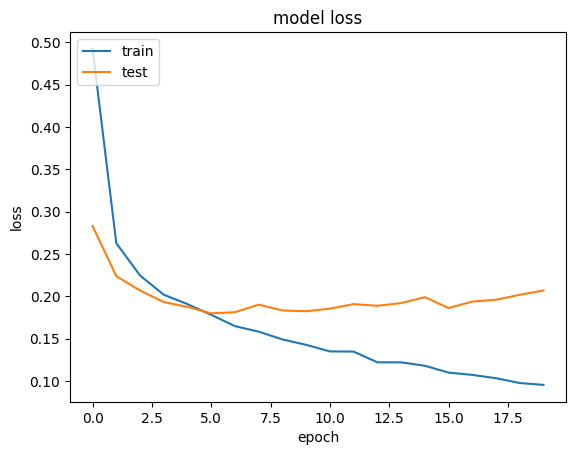

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [98]:
score = model.evaluate(X_test, y_test)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

235/235 [==============================] - 6s 25ms/step - loss: 0.2068 - accuracy: 0.9362
Test Loss: 0.2068345844745636
Test accuracy: 0.9361900687217712


235/235 [==============================] - 4s 17ms/step


<Axes: >

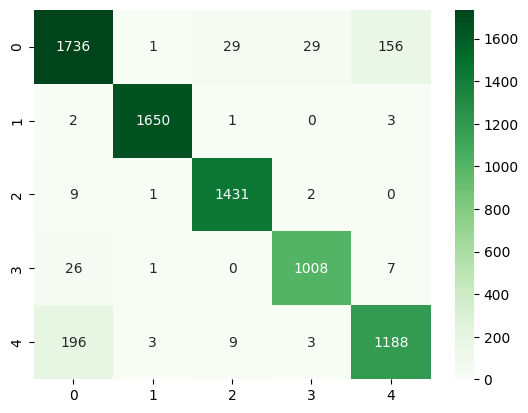

In [99]:
y_true=[]
for element in y_test:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(X_test)
prediction=np.argmax(prediction_proba,axis=1)

conf_mat = confusion_matrix(y_true, prediction)
sns.heatmap(conf_mat, annot=True,fmt='d', cmap='Greens')

**CNN 2**

In [100]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 360, 16)           224       
                                                                 
 average_pooling1d (Average  (None, 179, 16)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_9 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 average_pooling1d_1 (Avera  (None, 89, 32)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_10 (Conv1D)          (None, 89, 64)            34880     
                                                                 
 average_pooling1d_2 (Avera  (None, 44, 64)           

In [101]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [103]:
history = model.fit(X_train, y_train, batch_size=36, epochs=30, verbose=1, validation_data=(X_test, y_test))

Epoch 1/30
833/833 [==============================] - 89s 107ms/step - loss: 0.3089 - accuracy: 0.8986 - val_loss: 0.2638 - val_accuracy: 0.9127
Epoch 2/30
833/833 [==============================] - 84s 101ms/step - loss: 0.2706 - accuracy: 0.9104 - val_loss: 0.2325 - val_accuracy: 0.9247
Epoch 3/30
833/833 [==============================] - 82s 99ms/step - loss: 0.2500 - accuracy: 0.9165 - val_loss: 0.2346 - val_accuracy: 0.9230
Epoch 4/30
833/833 [==============================] - 85s 102ms/step - loss: 0.2361 - accuracy: 0.9203 - val_loss: 0.2139 - val_accuracy: 0.9296
Epoch 5/30
833/833 [==============================] - 87s 104ms/step - loss: 0.2212 - accuracy: 0.9252 - val_loss: 0.2153 - val_accuracy: 0.9283
Epoch 6/30
833/833 [==============================] - 82s 98ms/step - loss: 0.2142 - accuracy: 0.9246 - val_loss: 0.2122 - val_accuracy: 0.9319
Epoch 7/30
833/833 [==============================] - 84s 101ms/step - loss: 0.2071 - accuracy: 0.9282 - val_loss: 0.2141 - val_accu

In [104]:
score = model.evaluate(X_test, y_test)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

235/235 [==============================] - 7s 30ms/step - loss: 0.2310 - accuracy: 0.9315
Test Loss: 0.2310422956943512
Test accuracy: 0.9315178394317627


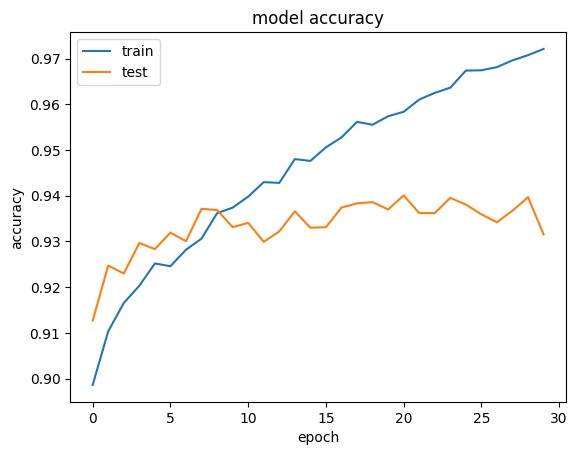

In [105]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()